In [2]:
import os
import sys
import numpy as np
import nibabel as nib
import pydicom
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numpy import zeros, newaxis
from scipy.stats import norm
import cv2
import scipy.signal as signal
from pydicom.pixel_data_handlers.util import apply_color_lut
from skimage.filters import threshold_multiotsu
from skimage.filters import threshold_otsu, threshold_local
import SimpleITK as sitk

In [40]:
root_eo06='/Users/mri_registration/SAMRI/samri_output/rEO_06/bids/sub-rEO_06/ses-postsurgery20240201/'
path_eo06='/Users/mri_registration/SAMRI/samri_output/rEO_06/bids/sub-rEO_06/ses-postsurgery20240201/anat/preopReg_sub-rEO_06_ses-postsurgery20240201_task-axial_acq-T2TurboRARE_T2w-ind_4.nii.gz'

In [41]:
nii_eo06=nib.load(path_eo06)
eo06_data=biascorrect_data(np.asanyarray(nii_eo06.dataobj))
# eo05_data=std_filt(eo05_data, 1)

In [64]:
eo06_20240201_bottom=[65, 69, 27]
eo06_20240201_top=[69, 109, 26.5]

In [61]:
new_affine=nii_eo06.affine.dot(axial2preop)

In [62]:
new_affine

array([[ 1.34267618e-01,  4.51087025e-03,  1.30389806e-02,
        -1.69487533e+01],
       [-1.44802610e-01,  6.35628977e-03,  3.96925249e-02,
         2.28509045e+01],
       [-1.09306008e+00, -9.01362600e-01,  4.27313580e+00,
         7.50880784e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [63]:
nii_eo06reg=nib.Nifti1Image(eo06_data, new_affine)
nib.save(nii_eo06reg, root_eo06+"test_axial.nii.gz")

cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:0
cnt:2
cnt:2
cnt:0
cnt:2
cnt:2
cnt:2
cnt:2
cnt:2
cnt:2


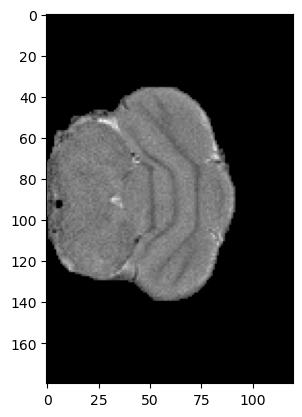

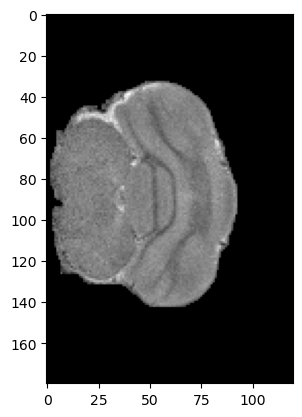

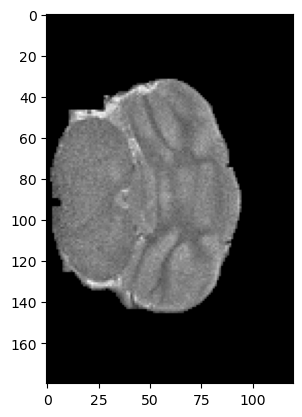

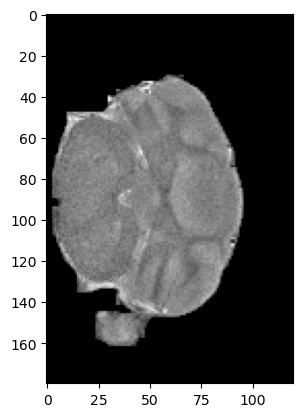

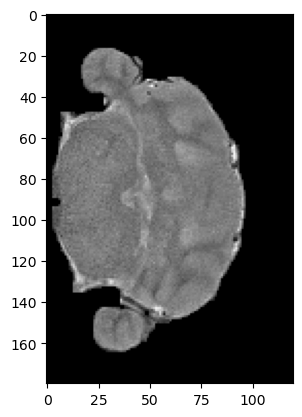

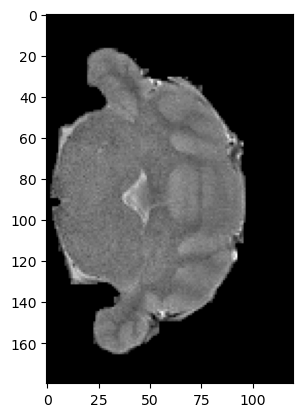

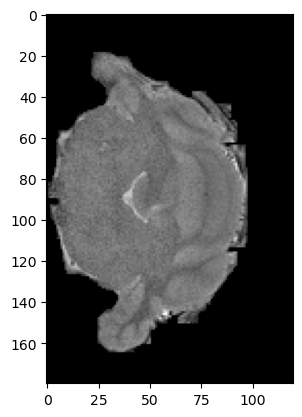

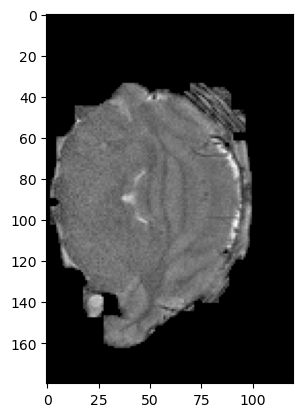

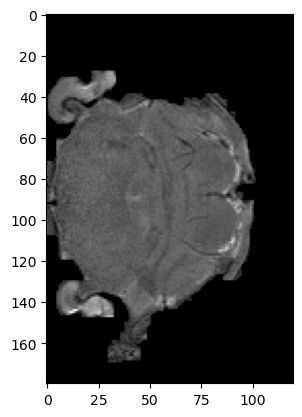

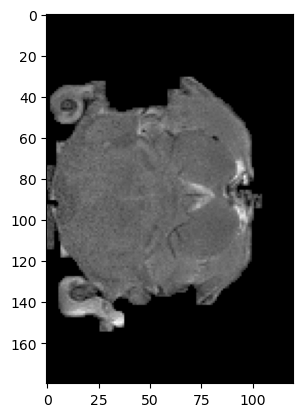

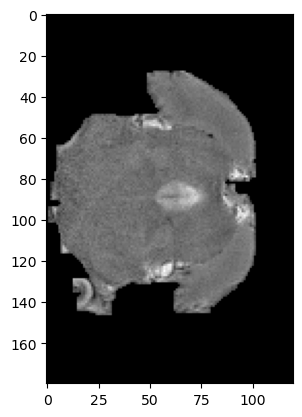

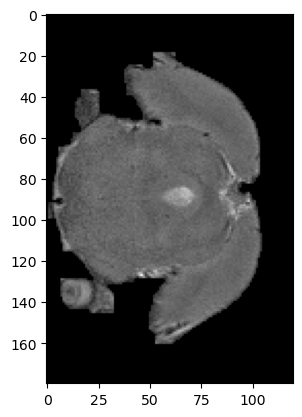

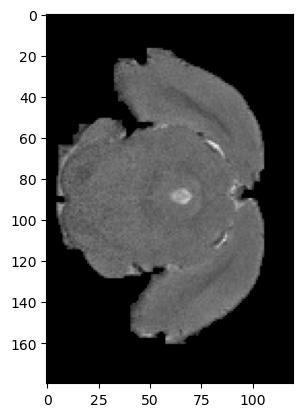

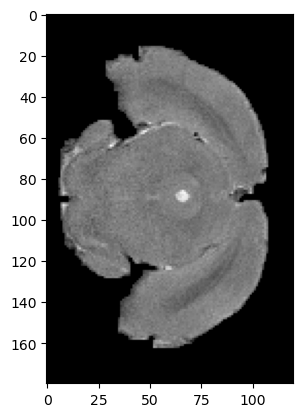

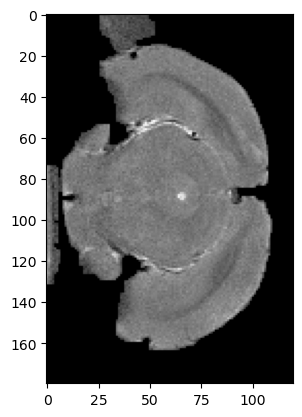

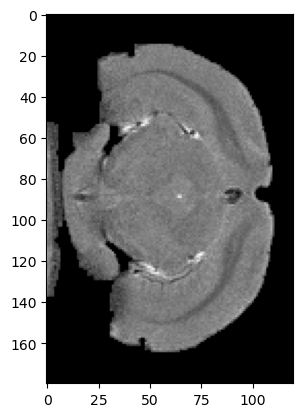

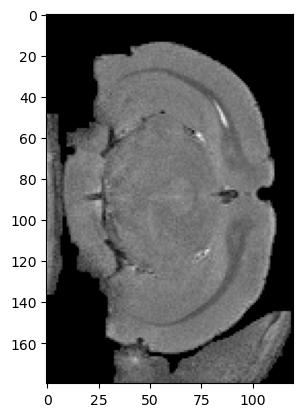

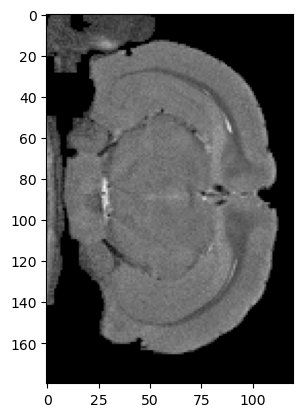

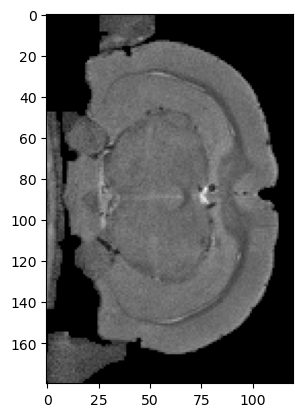

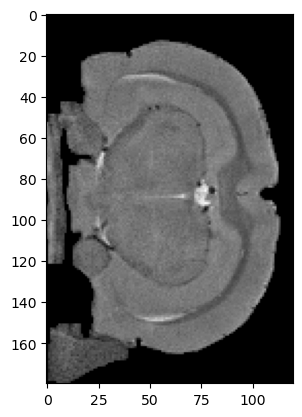

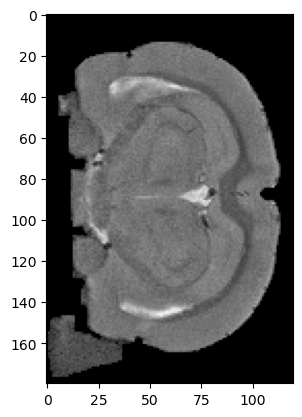

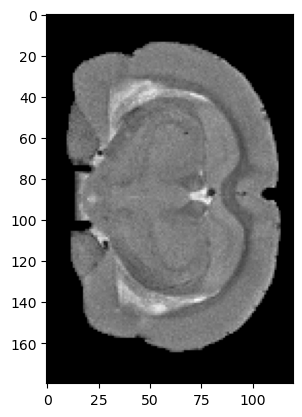

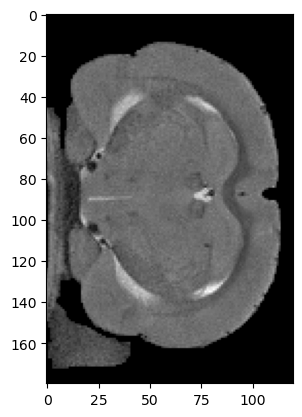

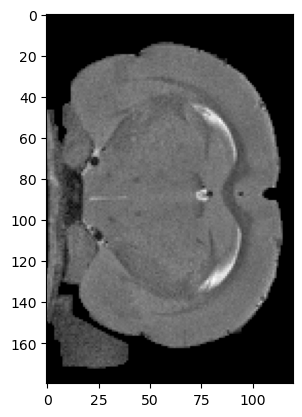

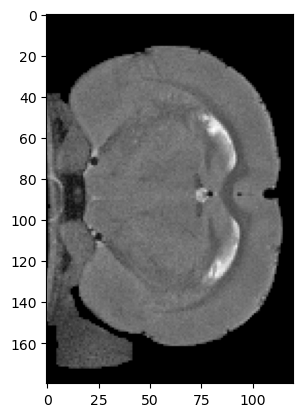

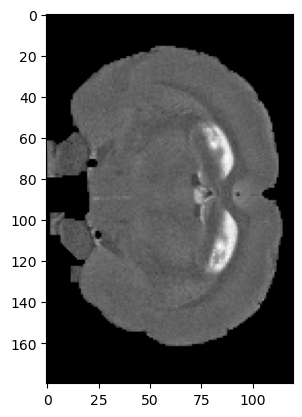

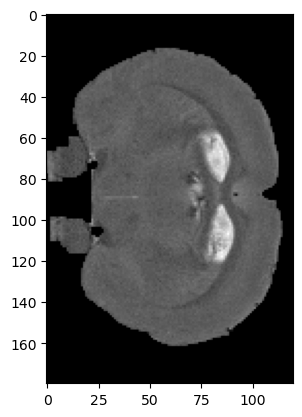

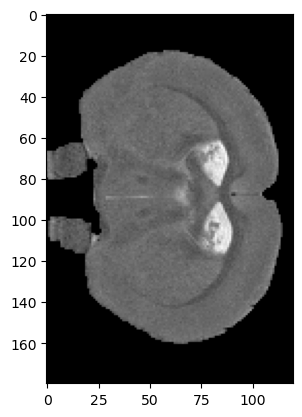

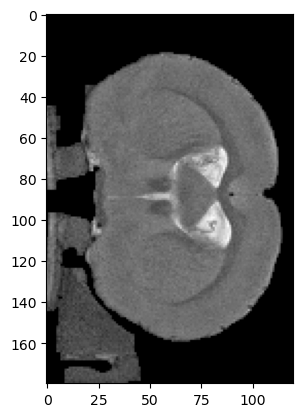

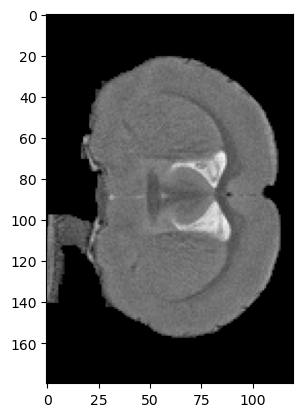

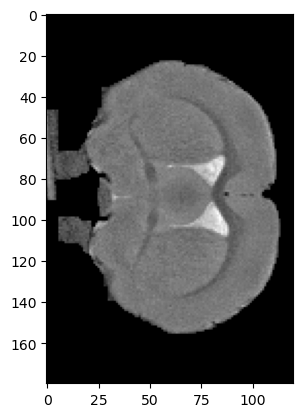

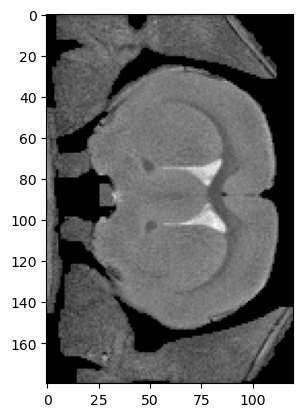

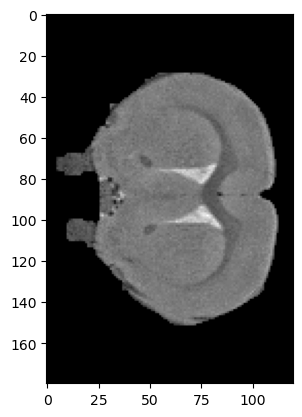

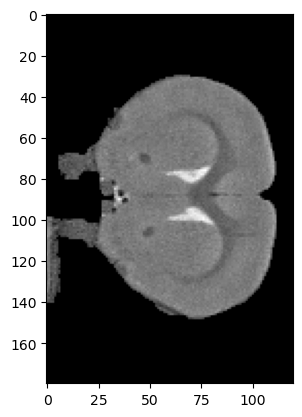

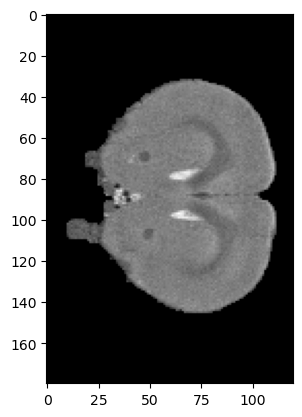

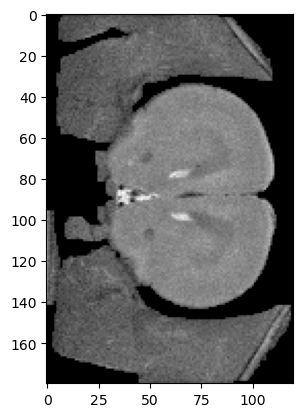

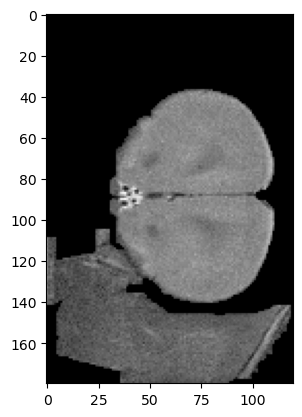

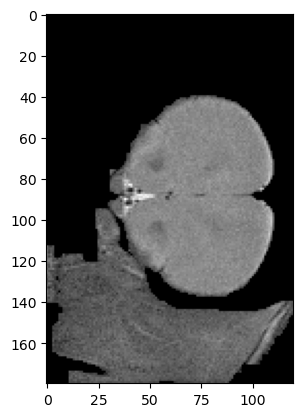

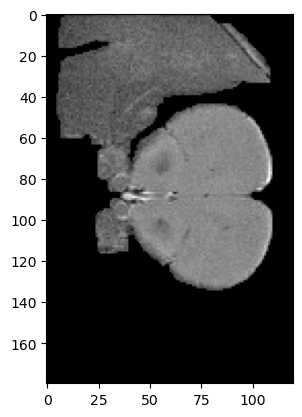

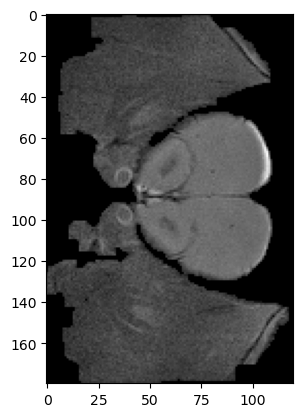

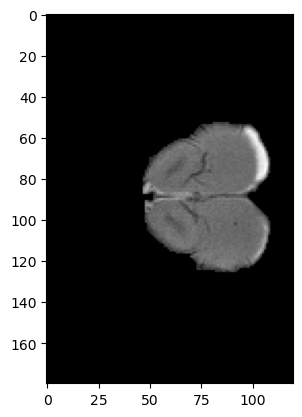

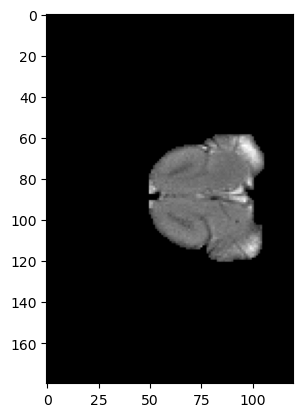

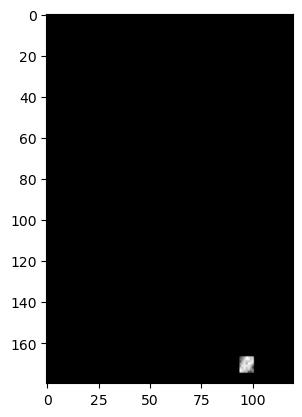

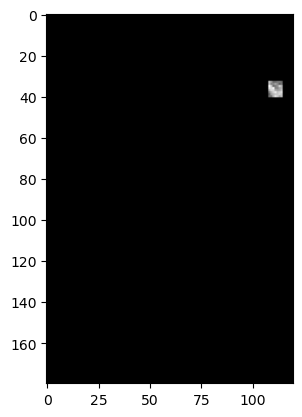

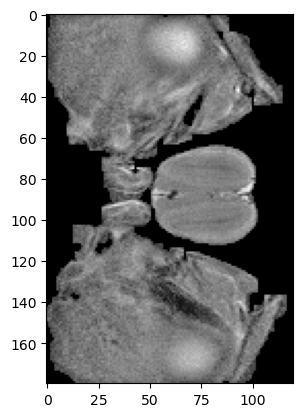

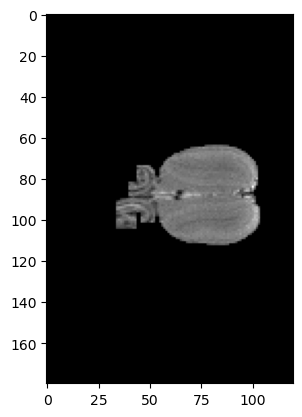

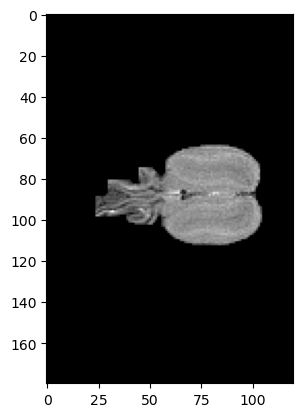

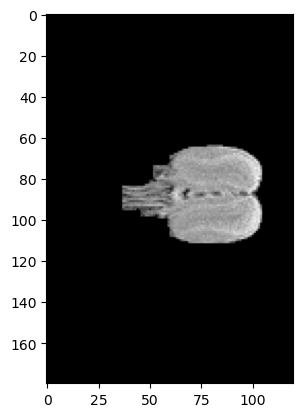

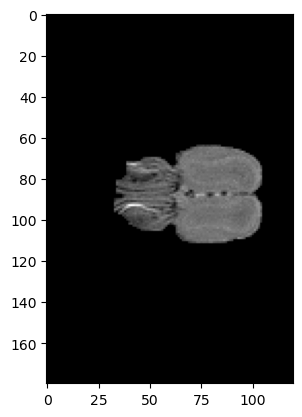

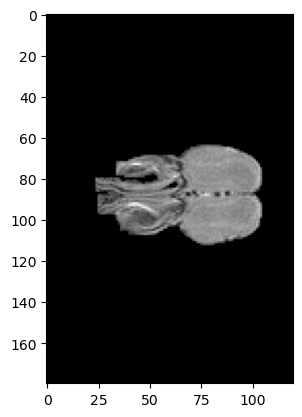

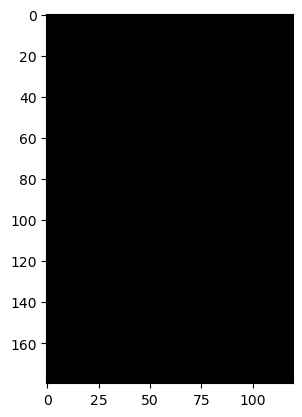

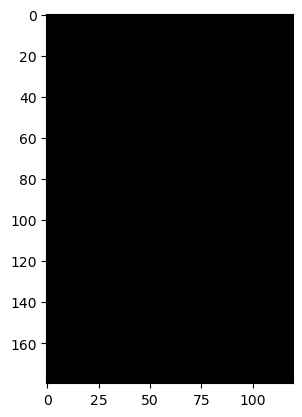

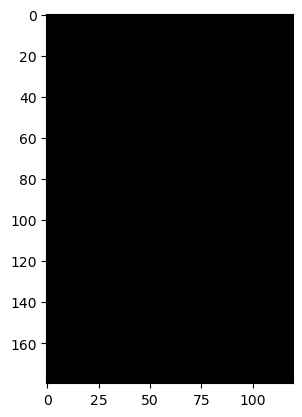

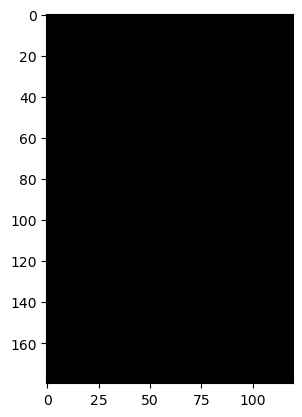

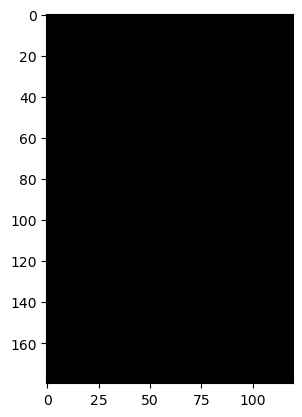

In [50]:
eo06_masked=get_brain(eo06_data, iterations=3)
eo06_masked[:,:,:5]=0
eo06_masked[:,:,-5:]=0
data_plotter(eo06_masked[:,:,5:])

In [51]:
nii_eo06reg=nib.Nifti1Image(eo06_masked, nii_eo06.affine)
nib.save(nii_eo06reg, root_eo06+'sub-rEO_06_ses-presurgery_task-rest_acq-TurboRAREreg_T2w-ind_00.nii.gz')

In [633]:
samri='/Users/eminhanozil/SAMRI/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_atlas_v4.nii.gz'
atlas=nib.load(samri)
atlas=np.asanyarray(atlas.dataobj)

In [165]:
A1=nii_img.affine
A2=nii_img2.affine
A2inv=np.linalg.inv(A2)
ijk2=[]
xyz=[]
for i in range(0,len(nii_data[:,0,0])):
    for j in range(0,len(nii_data[0,:,0])):
        for k in range(0,len(nii_data[0,0,:])):
            vec=np.array([i, j, k, 1])
            vec2=np.matmul(A1,vec)
            xyz.append(vec2)
#             vec2=np.matmul(A2inv, np.matmul(A1,vec))
#             ijk2=np.append(ijk2, vec2)

In [317]:
nii_data=np.asanyarray(nii_img.dataobj)
nii_data2=np.asanyarray(nii_img2.dataobj)
# avg_vol1=np.zeros([60,40,30])
# np.shape(avg_vol1)
A1=nii_img.affine
A2=nii_img2.affine
A2inv=np.linalg.inv(A2)
idx=0

nii_data=convert_grayscale(gaussian_blur(biascorrect_data(nii_data)))
nii_data2=convert_grayscale(gaussian_blur(biascorrect_data(nii_data2)))

In [341]:
df_mut_info = pd.DataFrame()
pxl1=[]
pxl2=[]
c=1
c2=1
rare2flash=np.zeros(tuple(nii_data.shape)[:3])
for i in range(0,math.floor(len(nii_data[:,0,0])/c)):
    for j in range(0,math.floor(len(nii_data[0,:,0])/c)):
        for k in range(len(nii_data[0,0,:])):
#             avg_pxl=np.mean()
#             vec=np.array([i, j, k, 1])
            xyz=np.matmul(A1,np.array([c*i, c*j, k, 1]))
            val1=np.mean(nii_data[c*i:c*i+c, c*j:c*j+c, k:k+c])
            pxl1.append(val1)
        
            ijk2=np.round(np.matmul(A2inv,xyz)).astype(int)[:3]
#             print(ijk2)
            i2,j2,k2=tuple(ijk2)
            val2=np.mean(nii_data2[i2:i2+c2,j2:j2+c2, k2])
            pxl2.append(val2)
            rare2flash[i,j,k]=val2
#             df_mut_info.loc[idx]=[pxl1, pxl2]
#             idx=idx+1\
df_mut_info['turboRare']=np.array(pxl1)
df_mut_info['t1flash']=np.array(pxl2)

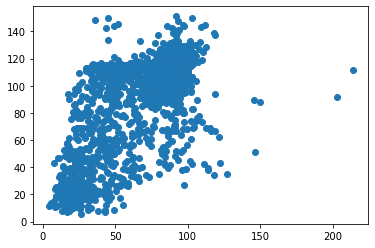

In [319]:
plt.scatter(df_mut_info['turboRare'], df_mut_info['t1flash'])

In [402]:
brain2=get_stripped_brain(rare2flash,(0,0))

In [440]:
A=nii_img3.affine
A_tmp=A.copy()
A_tmp[1,2]=A_tmp[1,2]/2
print(A_tmp)
vec1= np.matmul(A_tmp,np.array([0,0,0,1]))
vec2= np.matmul(A_tmp,np.array([1,0,0,1]))
print(np.linalg.norm(vec2-vec1))

[[ 6.83593750e-02  0.00000000e+00  0.00000000e+00 -1.70494156e+01]
 [ 0.00000000e+00 -3.78232420e-04  5.49991608e-01 -7.22804785e+00]
 [ 0.00000000e+00 -6.83583245e-02 -6.08630013e-03  1.62774220e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
0.068359375


In [453]:
A=nii_img3.affine
A_tmp=A.copy()
A_tmp[1,2]=A_tmp[1,2]/2

i,j,k=nii_data4.shape
t1flash_merged=np.zeros((i,j,2*k))

for i in range(k):
    t1flash_merged[:,:,2*i]=nii_data3[:,:,i]
    t1flash_merged[:,:,2*i+1]=nii_data4[:,:,i]
    

t1flash_merged_nii=nib.Nifti1Image(t1flash_merged, A_tmp)
nib.save(t1flash_merged_nii, 'rEO_05_t1flash_merged.nii.gz')

In [73]:
nii_data=np.asanyarray(nii_img.dataobj)
brain=get_stripped_brain(nii_data,(0,0))

In [454]:
path_t1='./rEO_05_t1flash_merged.nii.gz'
nii_t1=nib.load(path_t1)
# nii_data_t1=np.asanyarray(nii_t1.dataobj)
data=biascorrect_data(np.asanyarray(nii_t1.dataobj))

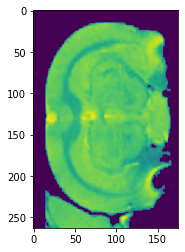

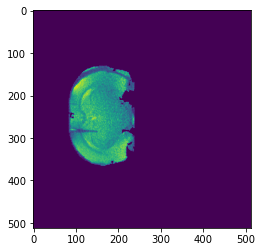

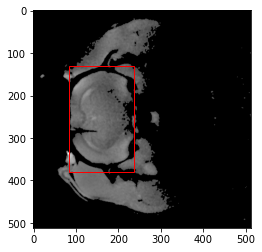

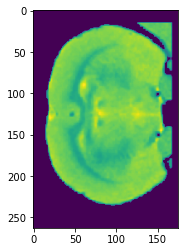

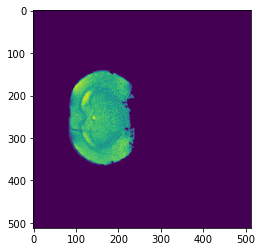

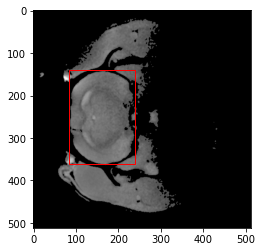

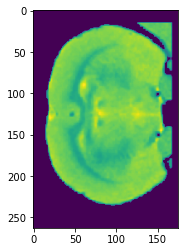

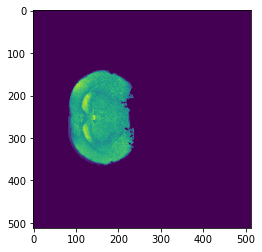

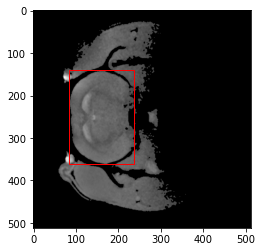

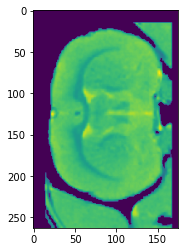

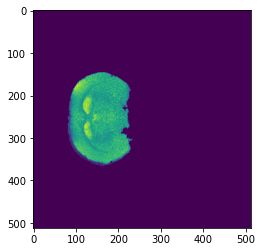

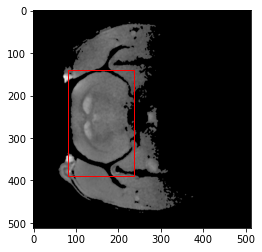

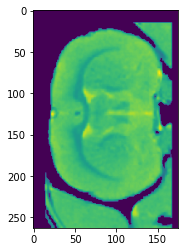

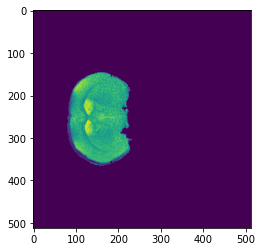

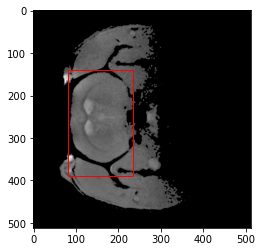

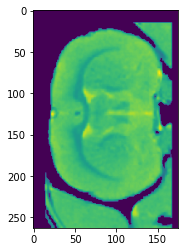

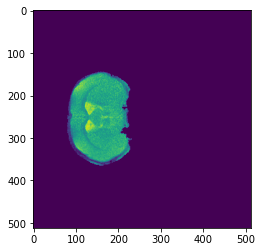

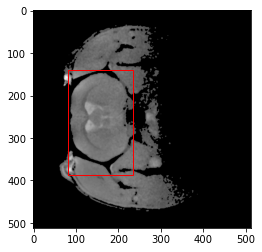

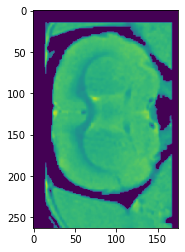

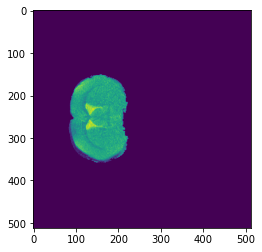

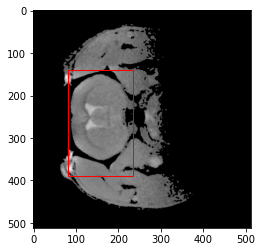

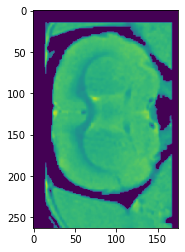

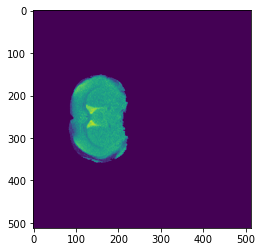

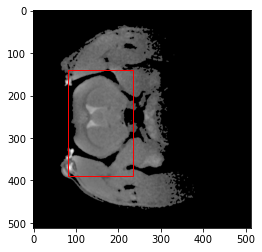

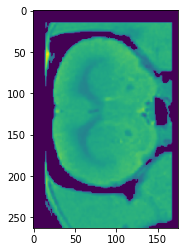

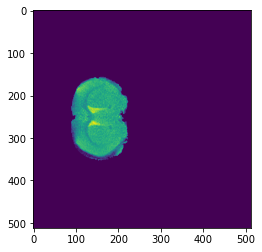

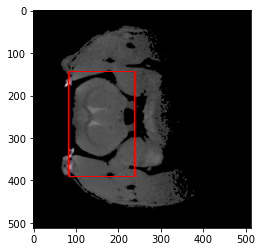

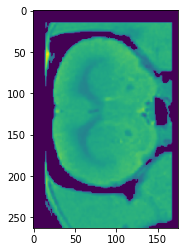

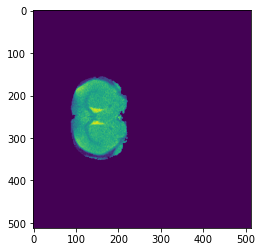

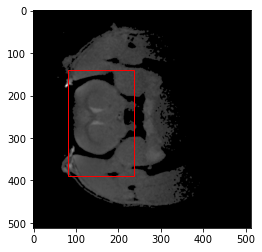

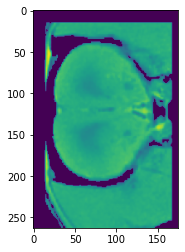

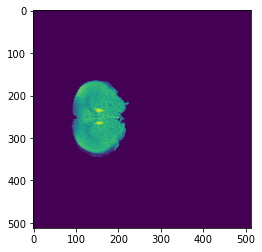

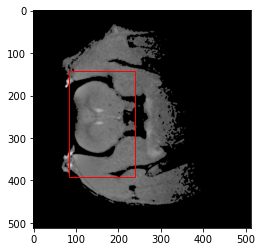

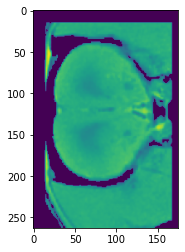

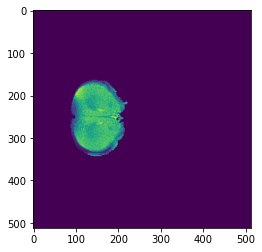

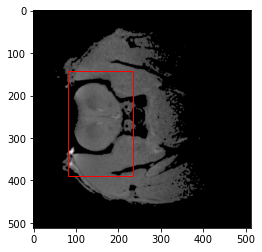

In [575]:
meth='cv2.TM_CCOEFF_NORMED'
color = (255, 255, 255) 
max_val=0
alpha=20
max_loc=[]
bbox_x=[]
bbox_y=[]
tmps=[]
ccoef=[]
method = eval(meth)
offset=20
n_slices=12
tmp_offset=25
tmp_n_slices=30
tmp_id=0
i,j,k=brain.shape
t1cropped=np.zeros(data.shape)
for nii_idx in range(offset,offset+n_slices):
    max_val=0
    img=gaussian_blur(data[:,:,nii_idx].astype(np.uint8))
    img=signal.medfilt2d(img)
    mask=multi_otsu(img,2)[0]>0.5
    img=convert_grayscale((img*mask))
    
    tmp=brain2[:,:,tmp_offset:tmp_offset+tmp_n_slices]

    for idx in range(0, len(tmp[0,0,:])):
        template=convert_grayscale((resize(tmp[:,:,idx])).astype(np.uint8))
        thresh, thr = multi_otsu(template,2)
        template=template*(thresh>0.5)
 
        # Apply template Matching
        res_tmp = cv2.matchTemplate(img,template,method)
        min_val, max_val_tmp, min_loc, max_loc_tmp = cv2.minMaxLoc(res_tmp)
        max_val_tmp=max_val_tmp*norm.pdf((idx-nii_idx+offset)/alpha)
        if max_val_tmp>max_val:
            tmp_id=idx
            max_val=max_val_tmp
            max_loc=max_loc_tmp
            best_template_uncropped=template
            best_template, h_top, w_left =remove_empty_space(template)
            w, h = best_template.shape[::-1]
            res=res_tmp

    top_left = max_loc
    ccoef.append(max_val)
    tmps.append(tmp_id)
    bbox_x.append(top_left[0])
    bbox_y.append(top_left[1])
    bottom_right = (top_left[0] + w, top_left[1] + h)
    mask=np.zeros(np.shape(img))
#     mask[top_left[1]:top_left[1] + h,top_left[0]:top_left[0] + w]=255

    brain_mask=convert_grayscale((resize(brain[:,:,tmp_id+25])).astype(np.uint8))
    w2, h2 = brain_mask.shape[::-1]
    mask[top_left[1]:top_left[1] + h2,top_left[0]:top_left[0] + w2]=(brain_mask>0)*1
#     fname1='./template_match/template_'+str(nii_idx)+'_'+str(tmp_id)+'.png'
#     fname2='./template_match/main_'+str(nii_idx)+'.png'
#     plt.imsave(fname1,best_template_uncropped,cmap='gray')
    plt.imshow(best_template_uncropped)
    plt.show()
    plt.imshow(data[:,:,nii_idx]*mask)
    plt.show()
    m=img.astype(np.uint8).copy()
    rect_left=(top_left[0]+w_left,top_left[1]+h_top)
    plot_rect(img, rect_left, w, h, save=False, fname=fname2)
    
    t1cropped[:,:,nii_idx]=data[:,:,nii_idx]*mask
#     t1cropped[top_left[1]:top_left[1]+h,rect_left[0]:rect_left[0]+w,nii_idx]=data[top_left[1]:top_left[1]+h,rect_left[0]:rect_left[0]+w,nii_idx]


In [526]:
outlier_x=np.where(bbox_x>np.mean(bbox_x)+np.std(bbox_x))[0][0]
outlier_y=np.where(np.mean(bbox_y)-bbox_y>np.std(bbox_y))[0][0]
# np.median(bbox_x[outlier-2:outlier+2])
outlier_y

10

In [577]:
t1cropped_nii=nib.Nifti1Image(t1cropped, nii_img3.affine)
nib.save(t1cropped_nii, '05_t1_cropped.nii.gz')

In [3]:
def lcm(a, b):
    return abs(a*b) // math.gcd(a, b)

In [4]:
def biascorrect_data(data, axis=2):
    if axis==2:
        for i in range(0, len(data[0,0,:])):
            test_img=data[:,:,i]
            plt.imsave('n4test.png',test_img)
            n4_test_img=n4bias(['n4test.png', "N4_corrected.nrrd", 1])
            corrected=convert_grayscale(sitk.GetArrayFromImage(n4_test_img['corrected_image']))
    #         plt.imshow(corrected)
    #         plt.show()
            data[:,:,i]=corrected
    elif axis==1:
        for i in range(0, len(data[0,:,0])):
            test_img=data[:,i,:]
            plt.imsave('n4test.png',test_img)
            n4_test_img=n4bias(['n4test.png', "N4_corrected.nrrd", 1])
            corrected=convert_grayscale(sitk.GetArrayFromImage(n4_test_img['corrected_image']))
    #         plt.imshow(corrected)
    #         plt.show()
            data[:,i,:]=corrected
        
    return data

In [5]:
def save_img(data,path):
    for i in range(0, len(data[0,0,:])):
        img=data[:,:,i]
        if np.sum(img)>0:
    #         plt.imshow(np.transpose(brain[:,:,i]))
            fname=path+str(i)+'.png'
            plt.imsave(fname,img,cmap='gray')
    #         plt.show()

In [6]:
def remove_empty_space(img):
    w_left=0
    w_right=img.shape[1]-1
    h_top=0
    h_bottom=img.shape[0]-1
    for i in range(1,len(img[0,:])):
        if np.sum(img[:,i])==0:
            w_left=i
        else:
            break

    for i in range(1,len(img[0,:])):
        if np.sum(img[:,-i])==0:
            w_right=-i
        else:
            break

    for i in range(1,len(img[:,0])):
        if np.sum(img[i,:])==0:
            h_top=i
        else:
            break

    for i in range(1,len(img[:,0])):
        if np.sum(img[-i,:])==0:
            h_bottom=-i
        else:
            break
    

    cropped_img=img[h_top:h_bottom,w_left:w_right]
    return cropped_img, h_top, w_left

In [7]:
def read_dicom(path):
    ds = pydicom.dcmread(path)
    #Use get_dicom_pixels() to get the pixels
    return ds

In [8]:
def get_dicom_pixels(ds):
    pixel_array=np.flip(ds.pixel_array)
    img = (np.maximum(pixel_array,0) / pixel_array.max()) * 255.0
    img = np.uint8(img)
    
    return img

In [9]:
def get_dicom_translation(ds):
    orient=ds.ImageOrientationPatient
    pos=ds.ImagePositionPatient
    
    return orient, pos

In [10]:
def find_lowest_ch_coord(contours, bond_x, bond_y):
    crd_y_lst=[]
    crd_x_lst=[]
    crd_y_max=0
    crd_x_max=0
    for cnt in contours : 
        approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True) 

        # Used to flatted the array containing 
        # the co-ordinates of the vertices. 
        n = approx.ravel()  
        i = 0

        for j in n : 
            if(i % 2 == 0): 
                x = n[i] 
                y = n[i + 1] 
                crd_max_tmp=y
                if crd_max_tmp>crd_y_max:
                    crd_y_max=crd_max_tmp
                    crd_x=x
                crd_x_lst.append(x)
                crd_y_lst.append(y)

            i = i + 1

    crd_y_lst=np.array(crd_y_lst)
    crd_x_lst=np.array(crd_x_lst)
    
    itemindex = np.where(crd_y_lst == crd_y_max)
    crd_x=crd_x_lst[itemindex].mean()
    
    y=crd_y_max+bond_y
    x=crd_x+bond_x
    
    return x,y

In [11]:
def crop_img(img, x0, y0, dx=90, dy=15):
    img=img[x0:x0+dx, y0:y0+dy]
    return img

In [12]:
def read_png(path, scale=cv2.IMREAD_GRAYSCALE):
    img=cv2.imread(path, scale)

    return img

In [13]:
def convert_grayscale(img):
    img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    return img

In [14]:
def gray2binary(mask):
    mask = np.divide(mask, 255)
    return mask

In [15]:
def multi_otsu(img, classes=3):
    """Returns regions, thresholds. the multi otsu segmented image and used thresholds"""
    thresholds = threshold_multiotsu(img, classes=classes)
    regions = np.digitize(img, bins=thresholds)
    
    return regions, thresholds

In [16]:
def multi2binary(img, thresh=0.5):
    img = np.digitize(img, bins=[thresh])
    return img

In [17]:
def get_largest_cnt(img, point):
    height, width = img.shape[0:2]
    if point==(0,0):
        x=width/2
        y=height/2
        point=(x,y)
    distMin=np.infty
#     print(x)
    contours=cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]
#     plt.imshow(img)
    cnt_center = sorted(contours, key=cv2.contourArea)[-1]
    for i in range(0,len(contours)):
        cnt = sorted(contours, key=cv2.contourArea)[-1-i]
        dist=cv2.pointPolygonTest(cnt, point, False)
        if dist>0:
            print("cnt:"+str(i))
            cnt_center=cnt
#             distMin=dist
            break
        else:
            cnt_center=cnt
        
#     print(distMin)
    return cnt_center

In [18]:
# def cnt_includes_point(cnts, point):
#     height, width = img.shape[0:2]
#     if point==(0,0):
#         x=width/2
#         y=height/2
#         point=(x,y)
#     distMin=np.infty

In [19]:
def mask_largest_cnt(img, otsu_mask, point):
    cnt=get_largest_cnt(otsu_mask, point)
    mask = np.zeros((np.shape(img)[0],np.shape(img)[1]), np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, -1)
#     if prev_cnt.size>4:
#         prev_mask_scaled=np.zeros((np.shape(img)[0],np.shape(img)[1]), np.uint8)
#         prev_cnt=scale_contour(prev_cnt,scale)
#         cv2.drawContours(prev_mask_scaled, [prev_cnt], -1, 255, -1)
# #         mask=(gray2binary(mask)*gray2binary(prev_mask_scaled)).astype('uint8')
#         mask=np.logical_and(mask, prev_mask_scaled).astype('uint8')
    masked=(gray2binary(mask)*img).astype('uint8')

#     dst = cv2.bitwise_and(image, image, mask=mask)
    return masked

In [20]:
def std_filt(data, alpha=1.5):
    for idx in range(len(data[0,0,:])):
        img=data[:,:,idx]
        img=signal.medfilt2d(img)
        img=img*(img>alpha*np.std(img))
        data[:,:,idx]=img
        
    return data

In [21]:
def get_brain(data, point=(0,0), iterations=3):
    tmp_data=np.zeros(np.shape(data))
    for idx in range(0,len(data[0,0,:])):
        img=data[:,:,idx]
        img=signal.medfilt2d(img)
        otsu_mask_tmp=convert_grayscale(multi2binary(multi_otsu(img,3)[0]))

        kernel = np.ones((3,3),np.uint8)
        erosed = cv2.erode(otsu_mask_tmp,kernel,iterations = iterations)
        cnt=get_largest_cnt(erosed, point)

        mask = np.zeros((np.shape(img)[0],np.shape(img)[1]), np.uint8)
        cv2.drawContours(mask, [cnt], -1, [255, 255,255], -1)

        mask_dilated=cv2.dilate(mask,kernel,iterations = iterations)
        tmp_data[:,:,idx]=convert_grayscale(mask_dilated*data[:,:,idx])
        
    return tmp_data

In [22]:
def extract_brain(img, brain_center, otsu_classes=3, thresh=0.5):
    otsu_mask=convert_grayscale(multi2binary(multi_otsu(img,otsu_classes)[0], thresh))
    brain=mask_largest_cnt(img, otsu_mask, brain_center)
    
    return brain    

In [23]:
def sorted_directory_listing_with_os_listdir(directory):
    items = os.listdir(directory)
    sorted_items = sorted(items)
    return sorted_items

In [24]:
def plot_multi_otsu(img, thresholds, regions):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

    # Plotting the original image.
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original')
    ax[0].axis('off')

    # Plotting the histogram and the two thresholds obtained from
    # multi-Otsu.
    ax[1].hist(img.ravel(), bins=255)
    ax[1].set_title('Histogram')
    for thresh in thresholds:
        ax[1].axvline(thresh, color='r')

    # Plotting the Multi Otsu result.
    ax[2].imshow(regions, cmap='jet')
    ax[2].set_title('Multi-Otsu result')
    ax[2].axis('off')

    plt.subplots_adjust()

    plt.show()

In [25]:
def scale_contour(cnt, scale):
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

In [26]:
def get_stripped_brain(nii_data, brain_center=(0,0), thresh=0.5):
    brain=np.zeros(np.shape(nii_data))
    for i in range(0, len(nii_data[0,0,:])):
        brain[:,:,i]=extract_brain(nii_data[:,:,i], brain_center, thresh=thresh)
        brain[:,:10,i]=0
        brain[:10,:,i]=0
        brain[:,-5:,i]=0
        plt.imshow(brain[:,:,i])
        plt.show()
        try:
            brain[:,:,i]=extract_brain(brain[:,:,i], brain_center,2)
        except:
            plt.imshow(brain[:,:,i])
    
#     brain[:,:,-5:]=0
#     brain[:,:,:10]=0
    return brain

In [27]:
def gaussian_blur(img, kernel_size=5, sigma=0):
    blur = cv2.GaussianBlur(img,(kernel_size,kernel_size),sigma)
    return blur

In [28]:
def plot_rect(img, loc, w, h, save=0, fname=''):
    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(img, cmap='gray')
    # Create a Rectangle patch
    rect = patches.Rectangle(loc, w, h, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    if save:
        plt.savefig(fname)
    plt.show()

In [29]:
def resize(img, scale= 100/68.35938):
    # percent of original size
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    dim = (width, height)
  
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [30]:
def n4bias(args):
    if len(args) < 2:
        print(
            "Usage: N4BiasFieldCorrection inputImage "
            + "outputImage [shrinkFactor] [maskImage] [numberOfIterations] "
            + "[numberOfFittingLevels]"
        )
        sys.exit(1)

    inputImage = sitk.ReadImage(args[0], sitk.sitkFloat32)
#     inputImage=args[0]
    image = inputImage

    if len(args) > 4:
        maskImage = sitk.ReadImage(args[4], sitk.sitkUInt8)
    else:
#         itk::simple::OtsuThreshold(itk::simple::Image const &,uint8_t,uint8_t,uint32_t,bool,uint8_t,bool)

        maskImage = sitk.OtsuThreshold(inputImage, 0, 1, 200)

    shrinkFactor = 1
    if len(args) > 3:
        shrinkFactor = int(args[2])
        if shrinkFactor > 1:
            image = sitk.Shrink(
                inputImage, [shrinkFactor] * inputImage.GetDimension()
            )
            maskImage = sitk.Shrink(
                maskImage, [shrinkFactor] * inputImage.GetDimension()
            )

    corrector = sitk.N4BiasFieldCorrectionImageFilter()

    numberFittingLevels = 4

    if len(args) > 6:
        numberFittingLevels = int(args[6])

    if len(args) > 5:
        corrector.SetMaximumNumberOfIterations(
            [int(args[5])] * numberFittingLevels
        )

    corrected_image = corrector.Execute(image, maskImage)

    log_bias_field = corrector.GetLogBiasFieldAsImage(inputImage)

    corrected_image_full_resolution = inputImage / sitk.Exp(log_bias_field)

#     sitk.WriteImage(corrected_image_full_resolution, args[2])

#     if shrinkFactor > 1:
#         sitk.WriteImage(
#             corrected_image, "Python-Example-N4BiasFieldCorrection-shrunk.nrrd"
#         )

    return_images = {"input_image": inputImage,
                     "mask_image": maskImage,
                     "log_bias_field": log_bias_field,
                     "corrected_image": corrected_image}
    return return_images

In [31]:
def data_plotter(data, medfilt=False):
    for i in range(0, len(data[0,0,:])):
        img=data[:,:,i]
        if medfilt:
            img=signal.medfilt2d(img)
        plt.imshow(img, cmap='gray')
        plt.show()

In [32]:
def medfilt(data, kernel=3):
    data_filt=data
    for i in range(0, len(data[0,0,:])):
        img=data[:,:,i]
        img=signal.medfilt2d(img, kernel)
        data_filt[:,:,i]=img
    return data_filt

In [33]:
def data_reader(path):
    files=sorted_directory_listing_with_os_listdir(path)
    for idx,file in enumerate(files):
        filename = os.fsdecode(file)
        if filename.endswith(".png"):
            img=read_png(path+filename)
            if idx==0:
                x=np.shape(img)[0]
                y=np.shape(img)[1]
                data=np.zeros((x,y,1))
                data[:,:,0]=img
            else:
                data=np.append(data,img[...,newaxis],2)
    print(np.shape(data))
    return data

In [34]:
# files=sorted_directory_listing_with_os_listdir(path)

# for file in files:
#     if file.startswith("."):
#         pass
#     else:
#         print(filename)
#         filename = os.fsdecode(file)
#         ds = read_dicom(path+filename)
#         img = get_dicom_pixels(ds)
#         brain=extract_brain(img)
#         plt.imshow(brain)
#         plt.show()

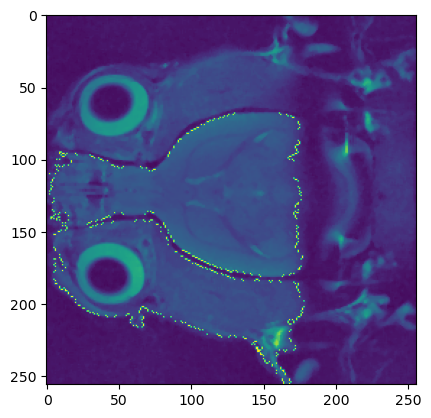

In [798]:
img=eo05_data[:,:,4]
img=signal.medfilt2d(img)
otsu_mask_tmp=convert_grayscale(multi2binary(multi_otsu(img,3)[0]))
_, contours, hierarchy =cv2.findContours(otsu_mask_tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


max_area=0
largest_cnt_idx=0
for idx, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    if area>max_area:
        max_area=area
        largest_cnt_idx=idx
        
imgcpy=img.copy()
cv2.drawContours(imgcpy, contours[largest_cnt_idx], -1, [255, 255,255], -1)
plt.imshow(imgcpy)

In [903]:
d=5
radius=100
cnt_tmp=contours[largest_cnt_idx].copy()
cnt_tmp2=contours[largest_cnt_idx].copy()
bridge_points=np.zeros((1,2))
for idx, point in enumerate(cnt_tmp):  
    distarr=np.linalg.norm(point-cnt_tmp, axis=2)
    idx_close_points=(np.indices(np.shape(distarr[:,0]))*(1*distarr[:,0]<d))
    p1=(idx-radius)%len(cnt_tmp)
    p2=(idx+radius)%len(cnt_tmp)
    
    if p2>p1:
        if np.any(idx_close_points[0][p1:p2]):
            for idx2 in idx_close_points[0]:
                if idx2>p1 and idx2<p2:
                    print(idx2)
                    bridge_points=np.append(bridge_points, cnt_tmp2[idx2], axis=0)
                    cnt_tmp=np.delete(cnt_tmp, (idx), axis=0)
    else:
        if np.any(idx_close_points[0][p2:p1]):
            for idx2 in idx_close_points[0]:
                if idx2<p1 and idx2>p2:
                    bridge_points=np.append(bridge_points, cnt_tmp2[idx2], axis=0)
                    cnt_tmp=np.delete(cnt_tmp, (idx), axis=0)
    

98
99
100
101
102
103
104
105
106
115
116
117
98
99
104
105
99
101
99
101
97
98
99
101
97
98
99
101
98
99
101
98
99
100
100
102
100
101
102
100
101
99
100
101
99
101
99
101
99
100
101
100
102
103
100
102
103
100
102
103
102
103
102
103
102
103
103
103
104
104
104
105
107
105
107
108
105
107
105
107
105
106
105
106
106
106
107
108
109
105
107
108
109
107
108
109
107
108
109
110
109
110
109
110
110
111
111
111
112
111
112
112
113
112
113
112
113
112
113
114
112
113
114
112
113
114
112
113
114
113
114
113
114
115
114
115
114
115
114
115
115
116
115
116
116
116
116
117
116
117
117
117
118
117
118
117
118
118
118
118
119
119
120
121
120
121
120
121
120
121
120
121
120
121
122
121
122
122
122
123
122
123
124
123
124
123
124
125
123
124
125
126
123
124
125
126
127
124
125
126
127
124
125
126
127
125
126
127
127
128
129
128
129
130
128
129
130
128
129
130
128
129
130
131
128
129
130
131
128
129
130
131
129
130
131
130
131
130
131
131
132
131
132


IndexError: index 254 is out of bounds for axis 0 with size 254

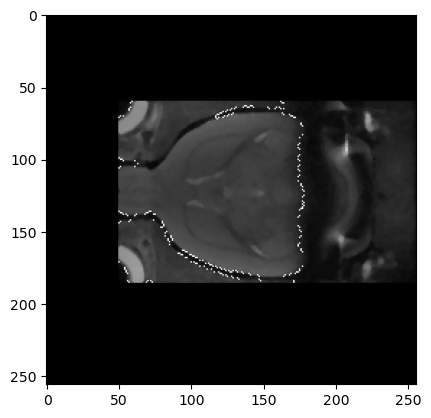

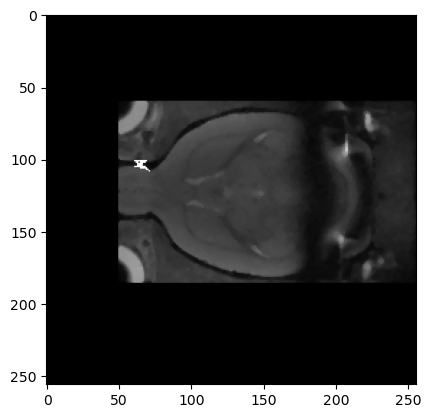

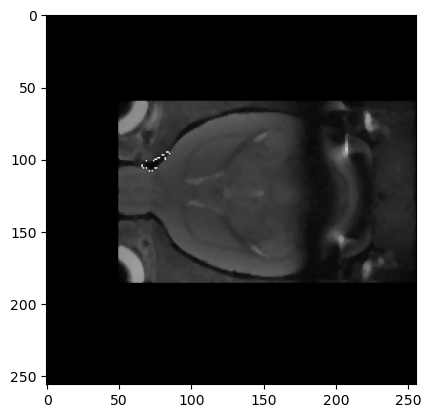

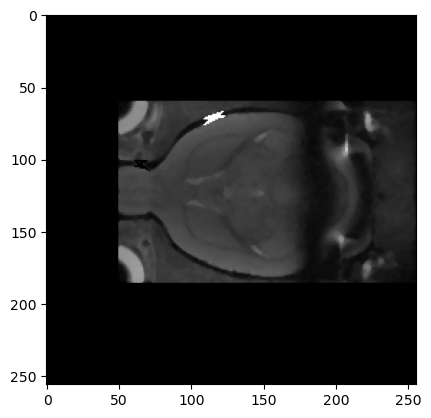

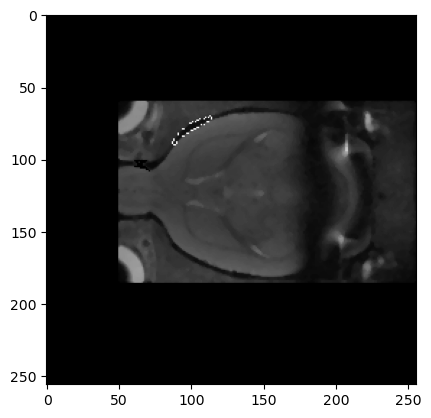

In [748]:
children=[]
for idx in (np.indices(np.shape(hierarchy[0][:,-1]))*(hierarchy[0][:,-1]==largest_cnt_idx))[0]:
    if idx!=0:
        children.append(contours[idx])
        
print(len(children))
print(largest_cnt_idx)


d=10
cnt_tmp=contours[largest_cnt_idx]
# bridge_points_parent=np.zeros((1,2))
# bridge_points_child=np.zeros((1,2))
# bridge=[]
alpha=0.1
# child =children[1]
imgcpy=img.copy()
cv2.drawContours(imgcpy, cnt_tmp, -1, [255, 255,255], -1)
plt.imshow(imgcpy,cmap='gray')
plt.show()
for child in children:
    bridge_points=np.zeros((1,2))
    for idx, point in enumerate(cnt_tmp):    
#         bridge_points_child=np.zeros((1,2))
        for child_index, child_point in enumerate(child):
            if np.linalg.norm(point-child_point)<d:
                bridge_points=np.append(bridge_points, point, 0)
                bridge_points=np.append(bridge_points, child_point, 0)

    bridge_points=np.delete(bridge_points, (0), axis=0)
#             bridge_points_child=np.delete(bridge_points_child, (0), axis=0)    
#             bridge_cnt = np.concatenate((np.unique(bridge_points_parent, axis=0), np.unique(bridge_points_child, axis=0)))
    try:
        bridge_cnt=bridge_points
        bridge_cnt=np.reshape(bridge_cnt,(np.shape(bridge_cnt)[0],1, -1))
        cnt_tmp2=np.zeros(np.shape(bridge_cnt))
        for idx, element in enumerate(bridge_cnt):
            cnt_tmp2[idx,:,:]=element
        cnt_tmp2=cnt_tmp2.astype('int32')
#         cnt_tmp2=np.sort(cnt_tmp2,0)
        mask = np.zeros((np.shape(img)[0],np.shape(img)[1]), np.uint8)
        cv2.drawContours(mask, [cnt_tmp2], -1, [255, 255,255], -1)
        imgcpy=img.copy()
        cv2.drawContours(imgcpy, [cnt_tmp2], -1, [255, 255,255], -1)
        plt.imshow(imgcpy,cmap='gray')
        plt.show()
        imgcpy=img.copy()
        cv2.drawContours(imgcpy, child, -1, [255, 255,255], -1)
        plt.imshow(imgcpy,cmap='gray')
        plt.show()
        img=(mask==0)*img
    except:
        print('child is far away')

            



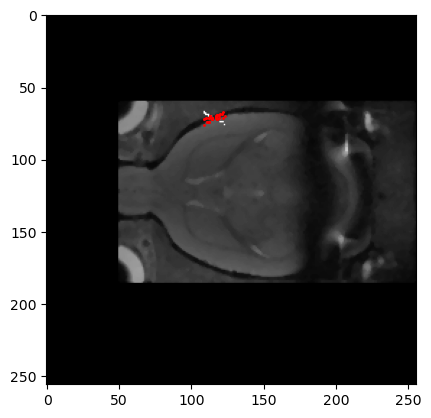

In [740]:
# plt.imshow(otsu_mask_tmp)
# plt.show()
mask = np.zeros((np.shape(img)[0],np.shape(img)[1]), np.uint8)
cpy=img.copy()
# cpy[:,int(np.min(x)):int(np.max(x))]=0
cv2.drawContours(cpy, cnt_tmp2, -1, [255, 255,255], -1)
plt.imshow(cpy,cmap='gray')
plt.scatter(bridge_cnt[:,0,0], bridge_cnt[:,0,1], s=0.5, c='red', marker='o')
plt.show()

In [31]:
# im = sitk.ReadImage(path_nii2)
# im.GetMetaData('dim_info')
# # for key in im.GetMetaDataKeys():
# #     print(im.GetMetaData(key))

In [13]:
def detect_blobs(img, minArea=100, minCirc=0.5, minConvx=0.9):
    params = cv2.SimpleBlobDetector_Params() 
  
    # Set Area filtering parameters 
    params.filterByArea = True
    params.minArea = minArea

    # Set Circularity filtering parameters 
    params.filterByCircularity = True 
    params.minCircularity = minCirc

    # Set Convexity filtering parameters 
    params.filterByConvexity = True
    params.minConvexity = minConvx

    #more elliptic less inertia, more circular more inertia
    # Set inertia filtering parameters 
    params.filterByInertia = True
    params.minInertiaRatio = 0.0001

    # Create a detector with the parameters 
    detector = cv2.SimpleBlobDetector_create(params) 
    
    # Detect blobs 
    keypoints = detector.detect(img) 

    # Draw blobs on our image as red circles 
    blank = np.zeros((1, 1))  
    blobs = cv2.drawKeypoints(img, keypoints, blank, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    #blobs variable can be directly plottable
#     plt.imshow(blobs)
    return blobs
